In [1]:
#-*- coding:utf8-*-
%matplotlib inline


from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns
sns.set(context="paper",font_scale=1.4)
sns.set_context(rc={'lines.markeredgewidth': 0.1}) # Momentaner Hack um "x" Marker verwenden zu können

import scipy as sp
import scipy.constants as const

import sympy as sym
import sympy.abc
from sympy import init_printing


import pandas as pd

import ROOT as rt

import root_numpy as rnp

from aputils.latextables.tables import Table


# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)


#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"

In [2]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

def axis_scale(axis="x",scale=1):
    if axis == "x":
        axis = plt.gca().xaxis
    elif axis == "y":
        axis = plt.gca().yaxis
    axis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,_ : float(x)*scale))
    
# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = map(len,description)
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)



##Klassen für die Bauteile

In [3]:
class Pipe:
    def __init__(self,diameter=0,length=0,diam_err=0,len_err=0):
        self.diameter = unc.ufloat(diameter,diam_err)
        self.length = unc.ufloat(length,len_err)
        
    @property
    def volume(self):
        return const.pi * (self.diameter**2/4) * self.length
        #self.eq_volume = self._volume_(self.diameter,self.length,eq=True)

class Tank(Pipe):
    def __init__(self,diameter=0,wall_thickness=0,length=0,diam_err=0,wall_err=0,len_err=0):
        self.diameter_outter = unc.ufloat(diameter,diam_err)
        self.wall_thickness = unc.ufloat(wall_thickness,wall_err)
        self.diameter = self.diameter_outter - self.wall_thickness
        self.length = unc.ufloat(length,len_err)
        
class TPipe:
    def __init__(self,diameter=0,length_l=0,length_s=0,diam_err=0,len_l_err=0,len_s_err=0):
        self.diameter = unc.ufloat(diameter,diam_err)
        self.length_long = unc.ufloat(length_l,len_l_err)
        self.length_short = unc.ufloat(length_s,len_s_err)
    @property
    def volume(self):    
        return const.pi * (self.diameter**2/4) * (self.length_long + self.length_short)
    
class XPipe:
    def __init__(self,diameter_l=0,diameter_s=0,length_l=0,length_s=0,
                 diam_l_err=0,diam_s_err=0,len_l_err=0,len_s_err=0):
        self.diameter_long = unc.ufloat(diameter_l,diam_l_err)
        self.diameter_short = unc.ufloat(diameter_s,diam_s_err)
        self.length_long = unc.ufloat(length_l,len_l_err)
        self.length_short = unc.ufloat(length_s,len_s_err)
        
    @property  
    def volume(self):
        return const.pi/4 * ((self.diameter_long**2 * self.length_long) + 
                            2*(self.diameter_short**2 * self.length_short))
class Valve(Pipe):
    def __init__(self,diameter=0,length=0,diam_err=0,len_err=0):
        Pipe.__init__(self,diameter=diameter,length=length,diam_err=diam_err,len_err=len_err)
    @property
    def volume_closed(self): 
        return self.volume/2  

### Verwendete Bauteile

In [4]:
# Tank
tank_front_connection = Pipe(diameter=38.5,length=130,diam_err=0.1,len_err=5) #mm
tank_maintank = Tank(diameter=155,diam_err=5,wall_thickness=4,wall_err=2,length=480,len_err=10)
tank_back_connection = Tank(diameter=28,diam_err=0.1,wall_thickness=2,wall_err=1,length=75,len_err=5)
tank_side_connection = Tank(diameter=38.3,diam_err=0.1,wall_thickness=4,wall_err=2,length=75,len_err=5)

In [5]:
volume_tank = (tank_front_connection.volume + tank_maintank.volume + 
                tank_back_connection.volume + tank_side_connection.volume)
print("Rezipienten Volumen",volume_tank/1000,"l")
volume_tank/1000

Rezipienten Volumen (8.9+/-0.6)e+03 l


8856.23549521898+/-638.8337479578076

In [6]:
# Rohre
pipe_tank_2_xpipe = Pipe(diameter=38,length=400,diam_err=5,len_err=5) #mm
pipe_smallest_0 =  Pipe(diameter=15,length=240,diam_err=2,len_err=5)
pipe_smallest_1 =  Pipe(diameter=15,length=240,diam_err=2,len_err=5)
pipe_xpipe_2_rotarypump = Pipe(diameter=15,length=440,diam_err=2,len_err=5)
flange_turbopump = Pipe(diameter=40,length=52,diam_err=1,len_err=5)

# X- und T-Stücke
xpipe_big = XPipe(diameter_l=39.5,diameter_s=16,length_l=130,length_s=40, # Kurze Längen und Fehler angepasst
                 diam_l_err=0.1,diam_s_err=0.1,len_l_err=5,len_s_err=5)   # Mittelwert der zwei Längen bis zum Zylinder
xpipe_small = XPipe(diameter_l=11,diameter_s=11,length_l=80,length_s=70, 
                 diam_l_err=0.1,diam_s_err=0.1,len_l_err=5,len_s_err=5)
tpipe_big = TPipe(diameter=40,length_l=129,length_s=46,diam_err=1,len_l_err=5,len_s_err=1)
tpipe_small = TPipe(diameter=11,length_l=80,length_s=36,diam_err=0.1,len_l_err=5,len_s_err=5)
tpipe_turbopump = TPipe(diameter=40,length_l=110,length_s=60,diam_err=1,len_l_err=20,len_s_err=10)

#Ventile
valve_lever_0 = Valve(diameter=15,length=77,diam_err=1,len_err=5) # Fehler angepasst
valve_lever_1 = Valve(diameter=15,length=77,diam_err=1,len_err=5)
valve_lever_2 = Valve(diameter=15,length=77,diam_err=1,len_err=5)
valve_lever_3 = Valve(diameter=15,length=77,diam_err=1,len_err=5)
valve_turbopump = Valve(diameter=40,length=33,diam_err=1,len_err=5)

In [7]:
print("Volumen der Rohre:")
print(pipe_tank_2_xpipe.volume/1000000)
print(pipe_smallest_0.volume/1000000)
print(pipe_xpipe_2_rotarypump.volume/1000000)
print(flange_turbopump.volume/1000000)
print("")
print("Volumen der X- & T-Stücke:")
print(xpipe_big.volume/1000000)
print(xpipe_small.volume/1000000)
print(tpipe_big.volume/1000000)
print(tpipe_small.volume/1000000)
print(tpipe_turbopump.volume/1000000)
print("")
print("Volumen der Ventile (offen,geschlossen):")
print(valve_lever_0.volume/1000000,",",valve_lever_0.volume_closed/1000000)
print(valve_turbopump.volume/1000000,",",valve_turbopump.volume_closed/1000000)



Volumen der Rohre:
0.45+/-0.12
0.042+/-0.011
0.078+/-0.021
0.065+/-0.007

Volumen der X- & T-Stücke:
0.175+/-0.007
0.0209+/-0.0011
0.220+/-0.013
0.0110+/-0.0007
0.214+/-0.030

Volumen der Ventile (offen,geschlossen):
0.0136+/-0.0020 , 0.0068+/-0.0010
0.041+/-0.007 , 0.0207+/-0.0033


In [8]:
# Sammlung aller Bauteile und Erstellung von Listen 
list_tank = [tank_front_connection,tank_maintank,tank_back_connection,tank_side_connection]
list_pipes = [pipe_tank_2_xpipe, pipe_smallest_0, pipe_smallest_1, pipe_xpipe_2_rotarypump,flange_turbopump]
list_xpipes = [xpipe_big,xpipe_small]
list_tpipes = [tpipe_big,tpipe_small,tpipe_turbopump]
list_valves = [valve_lever_0,valve_turbopump]
list_recipient_parts = list_tank + list_pipes+list_tpipes+list_xpipes+list_valves 

parts_volume = np.array([p.volume/1000 for p in list_recipient_parts]) # Volumen des gesammten Tanks ergänzen
parts_volume_closed =  np.array([p.volume_closed/1000 for p in list_valves])
parts_volume_closed = np.hstack([[-1]*(len(parts_volume)-3),parts_volume_closed])
def get_attribute_list(objs,attribute):
    return np.array([getattr(obj,attribute) if hasattr(obj,attribute) else -1 for obj in objs])
    
parts_diameter = get_attribute_list(list_recipient_parts,"diameter")
parts_diameter_l = get_attribute_list(list_recipient_parts,"diameter_long")
parts_diameter_s = get_attribute_list(list_recipient_parts,"diameter_short")
parts_length = get_attribute_list(list_recipient_parts,"length")
parts_length_l = get_attribute_list(list_recipient_parts,"length_long")
parts_length_s = get_attribute_list(list_recipient_parts,"length_short")
parts_diameter[np.where(parts_diameter == -1)[0]] = parts_diameter_l[np.where(parts_diameter == -1)[0]]
parts_length[np.where(parts_length == -1)[0]] = parts_length_l[np.where(parts_length == -1)[0]]

In [13]:
parts_diameter
parts_length

array([130.0+/-5.0, 480.0+/-10.0, 75.0+/-5.0, 75.0+/-5.0, 400.0+/-5.0,
       240.0+/-5.0, 240.0+/-5.0, 440.0+/-5.0, 52.0+/-5.0, 129.0+/-5.0,
       80.0+/-5.0, 110.0+/-20.0, 130.0+/-5.0, 80.0+/-5.0, 77.0+/-5.0,
       33.0+/-5.0], dtype=object)

In [10]:
# Tabelle mit den gemessenen Bauteilgrößen
# Spalten Durchmesser, Druchmesser2, Länge, Länge2, Volumen, Volumen geschlossen
parts_number = np.arange(1,16)
parts_Tab = Table(siunitx=True,booktabs=True)
parts_Tab.label("Bauteile_Abmessungen")
parts_Tab.caption("""Geometrische Abmessungen aller verwendeten Bauteile und die aus diesen berechneten Volumina.
                  Die Nummerierung entspricht der auf ABBILDUNG???.""")
parts_Tab.addColumn(parts_number, title="Bauteil Nummer",symbol="")
parts_Tab.addColumn(parts_diameter,title="Durchmesser (groß)",symbol="d_\\mathrm{g}",unit="mm")
parts_Tab.addColumn(parts_diameter_s,title="Durchmesser (klein)",symbol="d_\\mathrm{k}",unit="mm")
parts_Tab.addColumn(parts_length,title="Länge (groß)",symbol="l_\\mathrm{g}",unit="mm")
parts_Tab.addColumn(parts_length_s,title="Länge (klein)",symbol="l_\\mathrm{k}",unit="mm")
parts_Tab.addColumn(parts_volume,title="Volumen (offen)",symbol="V",unit=r"cm\cubed")
parts_Tab.addColumn(parts_volume_closed,title="Volumen (geschlossen)",symbol="V",unit=r"cm\cubed")
#Image(parts_Tab.show(ipynb=True,quiet=False),height=350)
parts_Tab.save(path_table+"Bauteil_Abmessungen.tex")

###  Volumen des gesamten Rezipienten für die einzelnen Versuche 

In [11]:
# Volumen des Rezipienten:
evac_rotarypump_volume_recipient_err = (volume_tank + pipe_tank_2_xpipe.volume + xpipe_big.volume 
                                    + tpipe_big.volume + tpipe_turbopump.volume+ valve_turbopump.volume_closed
                                    + valve_lever_0.volume + valve_lever_1.volume_closed + valve_lever_2.volume_closed
                                    + pipe_smallest_0.volume + pipe_smallest_1.volume + xpipe_small.volume
                                    + tpipe_small.volume + pipe_xpipe_2_rotarypump.volume + valve_lever_3.volume)
print("Volumen des Rezipienten Evak. Drehschieber:",evac_rotarypump_volume_recipient_err/1000000,"l")
# Das gleiche Volumen, einzige Veränderung Ventile auf->zu, Ventil zu->auf
leak_rotarypump_volume_recipient_err = (volume_tank + pipe_tank_2_xpipe.volume + xpipe_big.volume 
                                    + tpipe_big.volume + tpipe_turbopump.volume+ valve_turbopump.volume_closed
                                    + valve_lever_0.volume + valve_lever_1.volume_closed + valve_lever_2.volume_closed
                                    + pipe_smallest_0.volume + pipe_smallest_1.volume + xpipe_small.volume
                                    + tpipe_small.volume + pipe_xpipe_2_rotarypump.volume + valve_lever_3.volume)
print("Volumen des Rezipienten Leckrate Drehschieber:",evac_rotarypump_volume_recipient_err/1000000,"l")

# Volumen des Rezipienten Trubopumpe:
evac_turbopump_volume_recipient_err = (volume_tank + pipe_tank_2_xpipe.volume + xpipe_big.volume 
                                    + tpipe_big.volume + tpipe_turbopump.volume + valve_turbopump.volume
                                    + flange_turbopump.volume + valve_lever_0.volume_closed 
                                    + valve_lever_1.volume_closed)
print("Volumen des Rezipienten Evak. Turbo:",evac_turbopump_volume_recipient_err/1000000,"l")

# Veränderung Hebelventile zu->auf, Turboventil auf->zu
leak_turbopump_volume_recipient_err = (volume_tank + pipe_tank_2_xpipe.volume + xpipe_big.volume 
                                    + tpipe_big.volume + tpipe_turbopump.volume + valve_turbopump.volume_closed
                                    + flange_turbopump.volume + valve_lever_0.volume
                                    + valve_lever_1.volume_closed)
print("Volumen des Rezipienten Leckrate Turbo:",leak_turbopump_volume_recipient_err/1000000,"l")


Volumen des Rezipienten Evak. Drehschieber: 10.2+/-0.7 l
Volumen des Rezipienten Leckrate Drehschieber: 10.2+/-0.7 l
Volumen des Rezipienten Evak. Turbo: 10.0+/-0.7 l
Volumen des Rezipienten Leckrate Turbo: 10.0+/-0.7 l


### Laden der Daten

In [12]:
# Daten
evac_rotarypump = np.loadtxt(path_data+"Evakuierungskurve_Drehschieber.txt",unpack=True)
evac_turbopump_0 = np.loadtxt(path_data+"Evakuierungskurve_Turbo_0.txt",unpack=True) # 8e-04 - 1e-04
evac_turbopump_1 = np.loadtxt(path_data+"Evakuierungskurve_Turbo_1.txt",unpack=True) # 9e-05 - 3e-05

leak_rotarypump_0 = np.loadtxt(path_data+"Leckrate_Drehschieber_0.txt",unpack=True)
leak_rotarypump_1 = np.loadtxt(path_data+"Leckrate_Drehschieber_1.txt",unpack=True)
leak_rotarypump_2 = np.loadtxt(path_data+"Leckrate_Drehschieber_2.txt",unpack=True)
leak_rotarypump_3 = np.loadtxt(path_data+"Leckrate_Drehschieber_3.txt",unpack=True)

leak_turbopump_0 = np.loadtxt(path_data+"Leckrate_Turbo_0.txt",unpack=True)
leak_turbopump_1 = np.loadtxt(path_data+"Leckrate_Turbo_1.txt",unpack=True)
leak_turbopump_2 = np.loadtxt(path_data+"Leckrate_Turbo_2.txt",unpack=True)
leak_turbopump_3 = np.loadtxt(path_data+"Leckrate_Turbo_3.txt",unpack=True)

# Enddrücke
evac_rotarypump_endpressure,evac_turbopump_endpressure = np.loadtxt(path_data+"Evakuierungskurve_Enddruecke.txt",unpack=True)
leak_rotarypump_equipressures,leak_turbopump_equipressures = np.loadtxt(path_data+"Leckrate_Enddruecke.txt",unpack=True)

# Fehler
err_pressure,err_time = np.loadtxt(path_data+"Fehler_Drehschieber.txt",unpack=True)
err_pressure_turbo, error_time_turbo = np.loadtxt(path_data+"Fehler_Turbo.txt",unpack=True)

In [13]:
leak_rotarypump_equipressures

array([ 0.1,  0.2,  0.4,  0.8])

### Bearbeitung der Drehschieberpumpen-Daten

In [14]:
# Trennung in Druck und Zeitmesswerte
evac_rotarypump_pressure = evac_rotarypump[0]
evac_rotarypump_times = evac_rotarypump[1:]


leak_rotarypump_0_pressure = leak_rotarypump_0[0]
leak_rotarypump_0_times = leak_rotarypump_0[1:]
leak_rotarypump_1_pressure = leak_rotarypump_1[0]
leak_rotarypump_1_times = leak_rotarypump_1[1:]
leak_rotarypump_2_pressure = leak_rotarypump_2[0]
leak_rotarypump_2_times = leak_rotarypump_2[1:]
leak_rotarypump_3_pressure = leak_rotarypump_3[0]
leak_rotarypump_3_times = leak_rotarypump_3[1:]

# Fehlerbehaftete Messwerte
evac_rotarypump_endpressure_err = unc.ufloat(evac_rotarypump_endpressure,evac_rotarypump_endpressure*err_pressure/100)
evac_rotarypump_pressure_err = unp.uarray(evac_rotarypump_pressure,evac_rotarypump_pressure * err_pressure/100)
evac_rotarypump_pressure_log_err = unp.log((evac_rotarypump_pressure_err - evac_rotarypump_endpressure_err)/
                                           (evac_rotarypump_pressure_err[0]- evac_rotarypump_endpressure_err))
evac_rotarypump_times_err = unp.uarray(evac_rotarypump_times,np.ones_like(evac_rotarypump_times) * err_time)


leak_rotarypump_0_pressure_err = unp.uarray(leak_rotarypump_0_pressure,leak_rotarypump_0_pressure * err_pressure/100)
leak_rotarypump_0_times_err = unp.uarray(leak_rotarypump_0_times,np.ones_like(leak_rotarypump_0_times) * err_time)
leak_rotarypump_1_pressure_err = unp.uarray(leak_rotarypump_1_pressure,leak_rotarypump_1_pressure * err_pressure/100)
leak_rotarypump_1_times_err = unp.uarray(leak_rotarypump_1_times,np.ones_like(leak_rotarypump_1_times) * err_time)
leak_rotarypump_2_pressure_err = unp.uarray(leak_rotarypump_2_pressure,leak_rotarypump_2_pressure * err_pressure/100)
leak_rotarypump_2_times_err = unp.uarray(leak_rotarypump_2_times,np.ones_like(leak_rotarypump_2_times) * err_time)
leak_rotarypump_3_pressure_err = unp.uarray(leak_rotarypump_3_pressure,leak_rotarypump_3_pressure * err_pressure/100)
leak_rotarypump_3_times_err = unp.uarray(leak_rotarypump_3_times,np.ones_like(leak_rotarypump_3_times) * err_time)
leak_rotarypump_equipressures_err = unp.uarray(leak_rotarypump_equipressures,leak_rotarypump_equipressures*err_pressure_turbo/100) 

In [15]:
evac_rotarypump_pressure_log_err[0] = unc.ufloat(0,0)
evac_rotarypump_pressure_log_err

array([0.0+/-0, -0.5109589926645612+/-0.4243772406926737,
       -0.9165908369131704+/-0.42441263701645265,
       -1.6102383927650168+/-0.424518949991396,
       -2.3043870756620515+/-0.4247321350888694,
       -2.528031754523707+/-0.42483900789172085,
       -2.816549598022884+/-0.4250175456003658,
       -3.223688346689078+/-0.42537618811640115,
       -3.9218733212789805+/-0.42646476757911483,
       -4.625172873302944+/-0.4287000323235887,
       -4.8534315252839235+/-0.42984743683474097,
       -5.149697341427096+/-0.4318051646796112,
       -5.57255419224713+/-0.43589725676749896,
       -6.319768594077351+/-0.4497268457924024,
       -7.13069881029368+/-0.48608333915488305,
       -7.418380882745461+/-0.5099254965226205,
       -7.823845990853625+/-0.5612646530858691,
       -8.51699317141357+/-0.734846927735893], dtype=object)

In [16]:
# Mittelwert der Zeiten
# Für die Zeitmessung mitteln sich statistische Fehler raus, 
# hier: nur systematische Fehler => keine Verringerung durch mitteln
evac_rotarypump_time_mean = np.mean(evac_rotarypump_times,axis=0)
evac_rotarypump_time_std = np.std(evac_rotarypump_times,axis=0)

evac_rotarypump_time_mean_stat_err = unp.uarray(evac_rotarypump_time_mean,
                                                evac_rotarypump_time_std/np.sqrt(evac_rotarypump_times.shape[0]))
evac_rotarypump_time_mean_sys_err = unp.uarray(evac_rotarypump_time_mean,
                                               np.ones_like(evac_rotarypump_time_mean) * err_time)


leak_rotarypump_0_time_mean = np.mean(leak_rotarypump_0_times,axis=0)
leak_rotarypump_0_time_std = np.std(leak_rotarypump_0_times,axis=0)

leak_rotarypump_0_time_mean_stat_err = unp.uarray(leak_rotarypump_0_time_mean,
                                                leak_rotarypump_0_time_std/np.sqrt(leak_rotarypump_0_times.shape[0]))
leak_rotarypump_0_time_mean_sys_err = unp.uarray(leak_rotarypump_0_time_mean,
                                               np.ones_like(leak_rotarypump_0_time_mean) * err_time)


leak_rotarypump_1_time_mean = np.mean(leak_rotarypump_1_times,axis=0)
leak_rotarypump_1_time_std = np.std(leak_rotarypump_1_times,axis=0)

leak_rotarypump_1_time_mean_stat_err = unp.uarray(leak_rotarypump_1_time_mean,
                                                leak_rotarypump_1_time_std/np.sqrt(leak_rotarypump_1_times.shape[0]))
leak_rotarypump_1_time_mean_sys_err = unp.uarray(leak_rotarypump_1_time_mean,
                                               np.ones_like(leak_rotarypump_1_time_mean) * err_time)


leak_rotarypump_2_time_mean = np.mean(leak_rotarypump_2_times,axis=0)
leak_rotarypump_2_time_std = np.std(leak_rotarypump_2_times,axis=0)

leak_rotarypump_2_time_mean_stat_err = unp.uarray(leak_rotarypump_2_time_mean,
                                                leak_rotarypump_2_time_std/np.sqrt(leak_rotarypump_2_times.shape[0]))
leak_rotarypump_2_time_mean_sys_err = unp.uarray(leak_rotarypump_2_time_mean,
                                               np.ones_like(leak_rotarypump_2_time_mean) * err_time)


leak_rotarypump_3_time_mean = np.mean(leak_rotarypump_3_times,axis=0)
leak_rotarypump_3_time_std = np.std(leak_rotarypump_3_times,axis=0)

leak_rotarypump_3_time_mean_stat_err = unp.uarray(leak_rotarypump_3_time_mean,
                                                leak_rotarypump_3_time_std/np.sqrt(leak_rotarypump_3_times.shape[0]))
leak_rotarypump_3_time_mean_sys_err = unp.uarray(leak_rotarypump_3_time_mean,
                                               np.ones_like(leak_rotarypump_3_time_mean) * err_time)

### Bearbeitung der Turbopumpen-Daten

In [17]:
#Trennung von Druck- und Zeitdaten
#Evakuierungskurve
evac_turbopump_0_pressure = evac_turbopump_0[0]
evac_turbopump_0_times = evac_turbopump_0[1:]
evac_turbopump_1_pressure = evac_turbopump_1[0]
evac_turbopump_1_times = evac_turbopump_1[1:]


#Leckrate
leak_turbopump_0_pressure = leak_turbopump_0[0]
leak_turbopump_0_times = leak_turbopump_0[1:]
leak_turbopump_1_pressure = leak_turbopump_1[0]
leak_turbopump_1_times = leak_turbopump_1[1:]
leak_turbopump_2_pressure = leak_turbopump_2[0]
leak_turbopump_2_times = leak_turbopump_2[1:]
leak_turbopump_3_pressure = leak_turbopump_3[0]
leak_turbopump_3_times = leak_turbopump_3[1:]

#Fehlerbehaftete Messwerte
evac_turbopump_endpressure_err = unc.ufloat(evac_turbopump_endpressure,evac_turbopump_endpressure * err_pressure_turbo/100)
evac_turbopump_0_pressure_err = unp.uarray(evac_turbopump_0_pressure,evac_turbopump_0_pressure * err_pressure_turbo/100)
evac_turbopump_1_pressure_err = unp.uarray(evac_turbopump_1_pressure,evac_turbopump_1_pressure * err_pressure_turbo/100)

evac_turbopump_pressure_err = np.hstack([evac_turbopump_0_pressure_err, evac_turbopump_1_pressure_err])
evac_turbopump_pressure_log_err = unp.log((evac_turbopump_pressure_err- evac_turbopump_endpressure_err)/
                                          (evac_turbopump_pressure_err[0]- evac_turbopump_endpressure_err))

evac_turbopump_0_times_err = unp.uarray(evac_turbopump_0_times,np.ones_like(evac_turbopump_0_times) * err_time)
evac_turbopump_1_times_err = unp.uarray(evac_turbopump_1_times,np.ones_like(evac_turbopump_1_times) * err_time)
evac_turbopump_endpressure_err = unc.ufloat(evac_turbopump_endpressure,evac_turbopump_endpressure * err_pressure_turbo/100)



leak_turbopump_0_pressure_err = unp.uarray(leak_turbopump_0_pressure,leak_turbopump_0_pressure * err_pressure_turbo/100)
leak_turbopump_0_times_err = unp.uarray(leak_turbopump_0_times,np.ones_like(leak_turbopump_0_times) * err_time)
leak_turbopump_1_pressure_err = unp.uarray(leak_turbopump_1_pressure,leak_turbopump_1_pressure * err_pressure_turbo/100)
leak_turbopump_1_times_err = unp.uarray(leak_turbopump_1_times,np.ones_like(leak_turbopump_1_times) * err_time)
leak_turbopump_2_pressure_err = unp.uarray(leak_turbopump_2_pressure,leak_turbopump_2_pressure * err_pressure/100)
leak_turbopump_2_times_err = unp.uarray(leak_turbopump_2_times,np.ones_like(leak_turbopump_2_times) * err_time)
leak_turbopump_3_pressure_err = unp.uarray(leak_turbopump_3_pressure,leak_turbopump_3_pressure * err_pressure_turbo/100)
leak_turbopump_3_times_err = unp.uarray(leak_turbopump_3_times,np.ones_like(leak_turbopump_3_times) * err_time)
leak_turbopump_equipressures_err = unp.uarray(leak_turbopump_equipressures,leak_turbopump_equipressures*err_pressure_turbo/100) 

In [18]:
leak_turbopump_1_times

array([[ 2.25,  4.1 ,  5.82],
       [ 2.48,  4.43,  6.13],
       [ 3.16,  4.79,  7.34]])

In [19]:
leak_turbopump_1_times
#leak_turbopump_1_times[:,1:]

array([[ 2.25,  4.1 ,  5.82],
       [ 2.48,  4.43,  6.13],
       [ 3.16,  4.79,  7.34]])

In [20]:
evac_turbopump_pressure_log_err[0] = unc.ufloat(0,0)
evac_turbopump_pressure_log_err

array([0.0+/-0, -0.1364511027278575+/-0.14451894424135342,
       -0.29450803752218085+/-0.14480424018494542,
       -0.4823241136337762+/-0.14521023924889892,
       -0.7137664677626812+/-0.14583395311345662,
       -1.015434782189202+/-0.14691404985931317,
       -1.4494732627414224+/-0.14923592006702893,
       -2.2335922215070942+/-0.15771460026353237,
       -2.360343927146238+/-0.15996110458002566,
       -2.505525936990736+/-0.16298604943840084,
       -2.6754249737861335+/-0.16726419728672648,
       -2.880219386432147+/-0.17373953348100818,
       -3.1380484957342465+/-0.18456772943003358,
       -3.4863551900024623+/-0.20583150027764988,
       -4.02535169073515+/-0.262544496536094], dtype=object)

In [21]:
# Mittelwert der Zeiten
# Für die Zeitmessung mitteln sich statistische Fehler raus, 
# hier: nur systematische Fehler => keine Verringerung durch mitteln
evac_turbopump_0_time_mean = np.mean(evac_turbopump_0_times,axis=0)
evac_turbopump_1_time_mean = np.mean(evac_turbopump_1_times,axis=0)
evac_turbopump_0_time_std = np.std(evac_turbopump_0_times,axis=0)
evac_turbopump_1_time_std = np.std(evac_turbopump_1_times,axis=0)

evac_turbopump_0_time_mean_stat_err = unp.uarray(evac_turbopump_0_time_mean,
                                                evac_turbopump_0_time_std/np.sqrt(evac_turbopump_0_times.shape[0]))
evac_turbopump_1_time_mean_stat_err = unp.uarray(evac_turbopump_1_time_mean,
                                                evac_turbopump_1_time_std/np.sqrt(evac_turbopump_1_times.shape[0]))

evac_turbopump_0_time_mean_sys_err = unp.uarray(evac_turbopump_0_time_mean,
                                               np.ones_like(evac_turbopump_0_time_mean) * err_time)
evac_turbopump_1_time_mean_sys_err = unp.uarray(evac_turbopump_1_time_mean,
                                               np.ones_like(evac_turbopump_1_time_mean) * err_time)

evac_turbopump_time_mean_stat_err=np.hstack([evac_turbopump_0_time_mean_stat_err,evac_turbopump_1_time_mean_stat_err])
evac_turbopump_time_mean_sys_err = np.hstack([evac_turbopump_0_time_mean_sys_err,evac_turbopump_1_time_mean_sys_err])



leak_turbopump_0_time_mean = np.mean(leak_turbopump_0_times,axis=0)
leak_turbopump_0_time_std = np.std(leak_turbopump_0_times,axis=0)

leak_turbopump_0_time_mean_stat_err = unp.uarray(leak_turbopump_0_time_mean,
                                                leak_turbopump_0_time_std/np.sqrt(leak_turbopump_0_times.shape[0]))
leak_turbopump_0_time_mean_sys_err = unp.uarray(leak_turbopump_0_time_mean,
                                               np.ones_like(leak_turbopump_0_time_mean) * err_time)


leak_turbopump_1_time_mean = np.mean(leak_turbopump_1_times,axis=0)
leak_turbopump_1_time_std = np.std(leak_turbopump_1_times,axis=0)

leak_turbopump_1_time_mean_stat_err = unp.uarray(leak_turbopump_1_time_mean,
                                                leak_turbopump_1_time_std/np.sqrt(leak_turbopump_1_times.shape[0]))
leak_turbopump_1_time_mean_sys_err = unp.uarray(leak_turbopump_1_time_mean,
                                               np.ones_like(leak_turbopump_1_time_mean) * err_time)


leak_turbopump_2_time_mean = np.mean(leak_turbopump_2_times,axis=0)
leak_turbopump_2_time_std = np.std(leak_turbopump_2_times,axis=0)

leak_turbopump_2_time_mean_stat_err = unp.uarray(leak_turbopump_2_time_mean,
                                                leak_turbopump_2_time_std/np.sqrt(leak_turbopump_2_times.shape[0]))
leak_turbopump_2_time_mean_sys_err = unp.uarray(leak_turbopump_2_time_mean,
                                               np.ones_like(leak_turbopump_2_time_mean) * err_time)


leak_turbopump_3_time_mean = np.mean(leak_turbopump_3_times,axis=0)
leak_turbopump_3_time_std = np.std(leak_turbopump_3_times,axis=0)

leak_turbopump_3_time_mean_stat_err = unp.uarray(leak_turbopump_3_time_mean,
                                                leak_turbopump_3_time_std/np.sqrt(leak_turbopump_3_times.shape[0]))
leak_turbopump_3_time_mean_sys_err = unp.uarray(leak_turbopump_3_time_mean,
                                               np.ones_like(leak_turbopump_3_time_mean) * err_time)

### Evakuierungskurve der Drehschieberpumpe

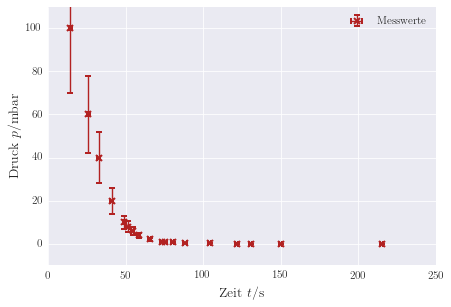

In [22]:
# Plot der Messwerte 
plt.errorbar(noms(evac_rotarypump_time_mean_sys_err),noms(evac_rotarypump_pressure_err),
             xerr=stds(evac_rotarypump_time_mean_sys_err),yerr=stds(evac_rotarypump_pressure_err),
             marker="x",mew=2,linestyle="",color="firebrick",label="Messwerte")

plt.ylim(-10,110)
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="mbar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Evakuierungskurve_Drehschieber_exp.pdf")

In [23]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(evac_rotarypump_time_mean_sys_err)
x_parts = np.split(x,[4,14]) 
y = noms(evac_rotarypump_pressure_log_err)
y_parts = np.split(y,[4,14]) 

X0 = np.linspace(np.min(x),np.max(x),1000)


popt0,pcov0 = sp.optimize.curve_fit(linear,x_parts[0],y_parts[0])
evac_fit_err0 = fit_errors(popt0,pcov0)
popt1,pcov1 = sp.optimize.curve_fit(linear,x_parts[1],y_parts[1])
evac_fit_err1 = fit_errors(popt1,pcov1)
popt2,pcov2 = sp.optimize.curve_fit(linear,x_parts[2],y_parts[2])
evac_fit_err2 = fit_errors(popt2,pcov2)

print("Fit im 1.Bereich")
print_errors(evac_fit_err0,["a =","b ="])

print("Fit im 2.Bereich")
print_errors(evac_fit_err1,["a =","b ="])

print("Fit im 3.Bereich")
print_errors(evac_fit_err2,["a =","b ="])



Fit im 1.Bereich
a =  -0.0590110020632 +/- 0.0068114313639
b =  0.92041914012 +/- 0.20517721592
Fit im 2.Bereich
a =  -0.0766523368479 +/- 0.00477396323738
b =  1.23548186669 +/- 0.343789112221
Fit im 3.Bereich
a =  -0.0139336543482 +/- 0.00211667511312
b =  -5.57400774906 +/- 0.335411241849


In [24]:
# Saugvermögen (Volumendurchsatz) in den 3 Bereichen 
y_parts = np.split(evac_rotarypump_pressure_err,[1,5,15])
evac_endpressures_err = np.array([p[0] for p in y_parts])
evac_endpressures_err = evac_endpressures_err[1:]
evac_flow_rate_0_err = - evac_rotarypump_volume_recipient_err * evac_fit_err0[0] 
evac_flow_rate_1_err = - evac_rotarypump_volume_recipient_err * evac_fit_err1[0]
evac_flow_rate_2_err = - evac_rotarypump_volume_recipient_err * evac_fit_err2[0]

evac_flow_rates_err = np.array([evac_flow_rate_0_err,evac_flow_rate_1_err,evac_flow_rate_2_err])/1000000

print_errors(evac_endpressures_err,["P0 = ","P1 =","P2 ="])
print()
print_errors(evac_flow_rates_err,["S0 =","S1 =","S2 ="])


P0 =   60.0 +/- 18.0
P1 =   8.0 +/- 2.4
P2 =   0.08 +/- 0.024

S0 =  0.600429548171 +/- 0.0792494597197
S1 =  0.779927918028 +/- 0.0696560633085
S2 =  0.141773186222 +/- 0.0233708675414


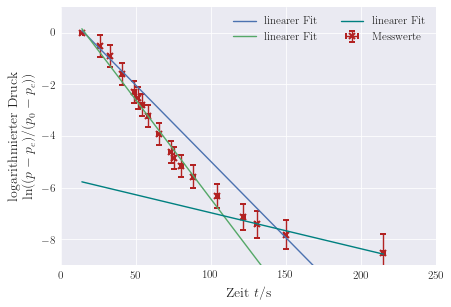

In [25]:
# Plot der logarithmierten Messwerte & 2.Fit
plt.errorbar(noms(evac_rotarypump_time_mean_sys_err),noms(evac_rotarypump_pressure_log_err),
             xerr=stds(evac_rotarypump_time_mean_sys_err),yerr=stds(evac_rotarypump_pressure_log_err),
             marker="x",mew=2,linestyle="",color="firebrick",label="Messwerte")
plt.plot(X0,linear(X0,*popt0),label="linearer Fit")
plt.plot(X0,linear(X0,*popt1),label="linearer Fit")
plt.plot(X0,linear(X0,*popt2),label="linearer Fit",color="teal")
plt.ylim(-9,1)
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("logarithmierter Druck\n",sym="\ln((p-p_e)/(p_0-p_e))"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
#plt.savefig(path_graphics+"Evakuierungskurve_Drehschieber_log_1.pdf")


In [26]:
# Plots der logarithmierten Messwerte & Fits

# Definition der Fraben (r,g,b)
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

for i,popt,color in zip(range(3),[popt0,popt1,popt2],[blue,green,"teal"]):
    plt.errorbar(noms(evac_rotarypump_time_mean_sys_err),noms(evac_rotarypump_pressure_log_err),
                 xerr=stds(evac_rotarypump_time_mean_sys_err),yerr=stds(evac_rotarypump_pressure_log_err),
                 marker="x",mew=2,linestyle="",color="firebrick",label="Messwerte")
    plt.plot(X0,linear(X0,*popt),label="linearer Fit",color=color)
    plt.ylim(-9,1)
    plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
    plt.ylabel(axis_label("logarithmierter Druck\n",sym="\ln((p-p_e)/(p_0-p_e))"),axis_font)
    plt.legend(loc="best",ncol=2)
    plt.tight_layout()
    plt.savefig(path_graphics+"Evakuierungskurve_Drehschieber_log_{}.pdf".format(i))
    plt.clf()

### Tabelle zur Evakuierungskurve

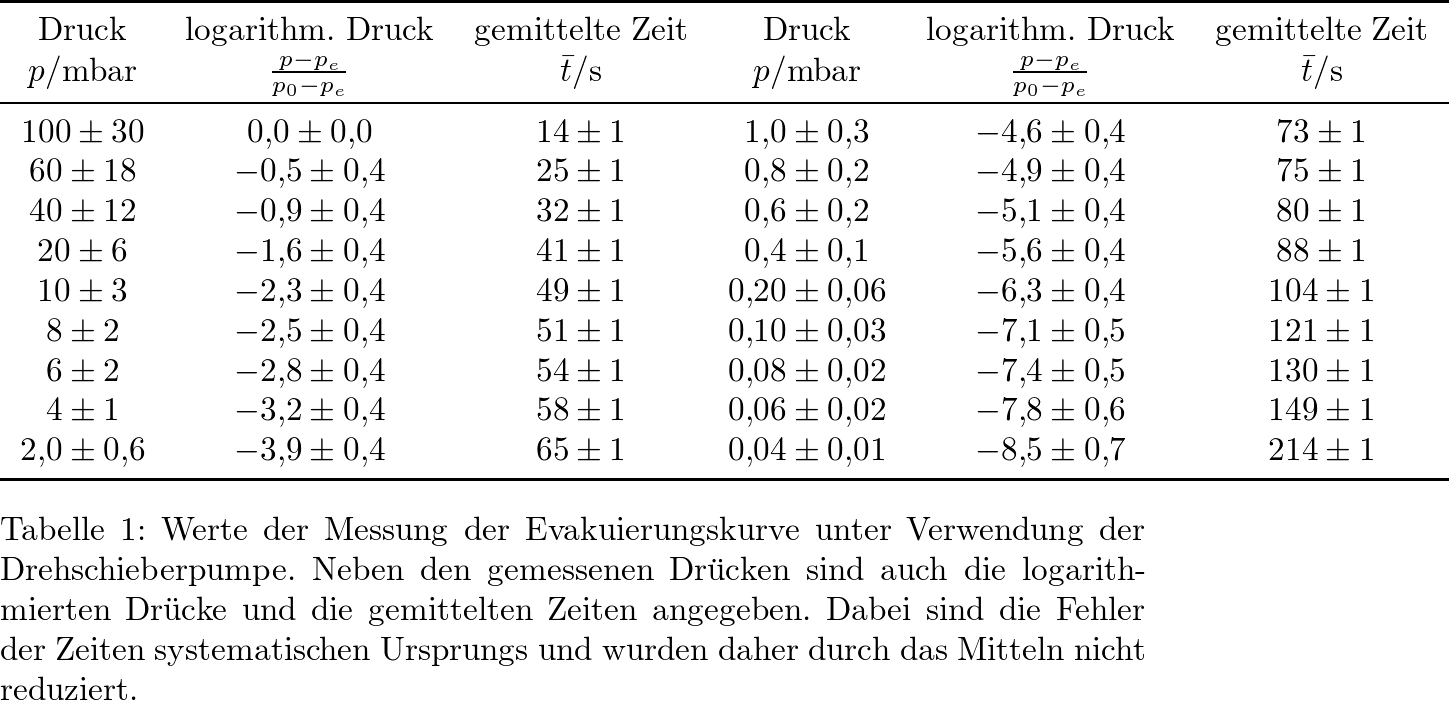

In [27]:
evac_rotary_Tab = Table(siunitx=True,booktabs=True)
evac_rotary_Tab.label("Evakuierungskurve_Drehschieber")
evac_rotary_Tab.caption("""Werte der Messung der Evakuierungskurve unter Verwendung der Drehschieberpumpe.
                        Neben den gemessenen Drücken sind auch die logarithmierten Drücke und die gemittelten
                        Zeiten angegeben. Dabei sind die Fehler der Zeiten systematischen Ursprungs und wurden 
                        daher durch das Mitteln nicht reduziert.""")
evac_rotary_Tab.addColumn(evac_rotarypump_pressure_err[:9],title="Druck",symbol="p",unit="mbar")
evac_rotary_Tab.addColumn(evac_rotarypump_pressure_log_err[:9],title="logarithm. Druck",symbol="\\frac{p-p_e}{p_0-p_e}")
evac_rotary_Tab.addColumn(evac_rotarypump_time_mean_sys_err[:9],title="gemittelte Zeit",symbol="\\bar{t}",unit="s")
evac_rotary_Tab.addColumn(evac_rotarypump_pressure_err[9:],title="Druck",symbol="p",unit="mbar")
evac_rotary_Tab.addColumn(evac_rotarypump_pressure_log_err[9:],title="logarithm. Druck",symbol="\\frac{p-p_e}{p_0-p_e}")
evac_rotary_Tab.addColumn(evac_rotarypump_time_mean_sys_err[9:],title="gemittelte Zeit",symbol="\\bar{t}",unit="s")
#evac_rotary_Tab.save(path_table+"Evakuierungskurve_Drehschieber.tex")
Image(evac_rotary_Tab.show(ipynb=True,quiet=False),height=300)

### Leckrate der Drehschieberpumpe

In [28]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(leak_rotarypump_0_time_mean_sys_err)
y = noms(leak_rotarypump_0_pressure_err)

X = np.linspace(np.min(x),np.max(x),1000)

popt,pcov = sp.optimize.curve_fit(linear,x,y)
leak_fit_0_err = fit_errors(popt,pcov)
print_errors(leak_fit_0_err,["a =","b ="])

a =  0.00343320969805 +/- 0.000232609369483
b =  0.16437881839 +/- 0.0194087844156


In [29]:
# Saugvermögen
V = leak_rotarypump_volume_recipient_err 
Pg = leak_rotarypump_equipressures_err[0]
leak_flow_rate_0_err = V/Pg * leak_fit_0_err[0]
print("Saugvermögen",leak_flow_rate_0_err/1000000)

Saugvermögen 0.35+/-0.05


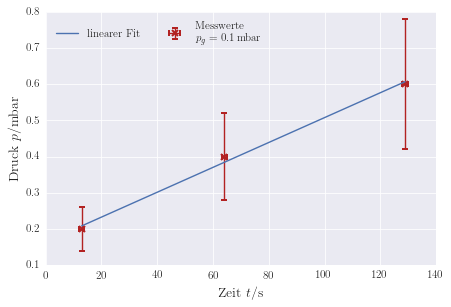

In [30]:
#Plot der Messwerte
plt.errorbar(noms(leak_rotarypump_0_time_mean_sys_err),noms(leak_rotarypump_0_pressure_err),
             xerr=stds(leak_rotarypump_0_time_mean_sys_err),yerr=stds(leak_rotarypump_0_pressure_err),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte \n$p_{g}=0.1\\,\\mathrm{mbar}$")
plt.plot(X,linear(X,*popt),label="linearer Fit")
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="mbar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Leckrate_Drehschieber_0.pdf")

In [31]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(leak_rotarypump_1_time_mean_sys_err)
y = noms(leak_rotarypump_1_pressure_err)

X = np.linspace(np.min(x),np.max(x),1000)

popt,pcov = sp.optimize.curve_fit(linear,x,y)
leak_fit_1_err = fit_errors(popt,pcov)
print_errors(leak_fit_1_err,["a =","b ="])

a =  0.00734136153034 +/- 0.000159807738651
b =  0.267199767693 +/- 0.00806919876938


In [32]:
# Saugvermögen
V = leak_rotarypump_volume_recipient_err 
Pg = leak_rotarypump_equipressures_err[1]
leak_flow_rate_1_err = V/Pg * leak_fit_1_err[0]
print("Saugvermögen",leak_flow_rate_1_err/1000000)

Saugvermögen 0.37+/-0.05


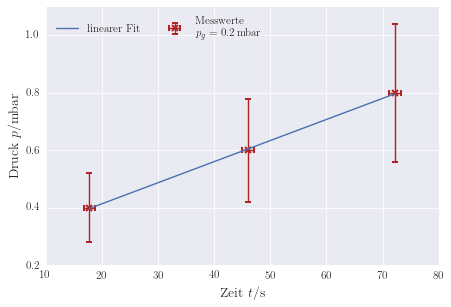

In [33]:
#Plot der Messwerte
plt.errorbar(noms(leak_rotarypump_1_time_mean_sys_err),noms(leak_rotarypump_1_pressure_err),
             xerr=stds(leak_rotarypump_1_time_mean_sys_err),yerr=stds(leak_rotarypump_1_pressure_err),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte\n $p_{g}=0.2\\,\\mathrm{mbar}$")

plt.plot(X,linear(X,*popt),label="linearer Fit")
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="mbar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Leckrate_Drehschieber_1.pdf")

In [34]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(leak_rotarypump_2_time_mean_sys_err)
y = noms(leak_rotarypump_2_pressure_err)

X = np.linspace(np.min(x),np.max(x),1000)

popt,pcov = sp.optimize.curve_fit(linear,x,y)
leak_fit_2_err = fit_errors(popt,pcov)
print_errors(leak_fit_2_err,["a =","b ="])

a =  0.0112064202218 +/- 0.00283513818665
b =  0.534856097298 +/- 0.0781266429063


In [35]:
# Saugvermögen
V = leak_rotarypump_volume_recipient_err 
Pg = leak_rotarypump_equipressures_err[2]
leak_flow_rate_2_err = V/Pg * leak_fit_2_err[0]
print("Saugvermögen",leak_flow_rate_2_err/1000000)

Saugvermögen 0.29+/-0.08


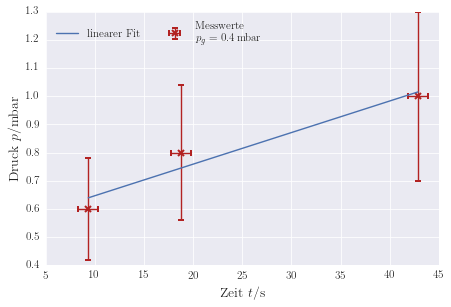

In [36]:
#Plot der Messwerte
plt.errorbar(noms(leak_rotarypump_2_time_mean_sys_err),noms(leak_rotarypump_2_pressure_err),
             xerr=stds(leak_rotarypump_2_time_mean_sys_err),yerr=stds(leak_rotarypump_2_pressure_err),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte\n $p_{g}=0.4\\,\\mathrm{mbar}$")
plt.plot(X,linear(X,*popt),label="linearer Fit")
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="mbar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Leckrate_Drehschieber_2.pdf")

In [37]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(leak_rotarypump_3_time_mean_sys_err)
y = noms(leak_rotarypump_3_pressure_err)

X = np.linspace(np.min(x),np.max(x),1000)

popt,pcov = sp.optimize.curve_fit(linear,x,y)
leak_fit_3_err = fit_errors(popt,pcov)
print_errors(leak_fit_3_err,["a =","b ="])

a =  0.0938182823124 +/- 0.000686074570844
b =  0.786723830802 +/- 0.0263582331142


In [38]:
# Saugvermögen
V = leak_rotarypump_volume_recipient_err 
Pg = leak_rotarypump_equipressures_err[3]
leak_flow_rate_3_err= V/Pg * leak_fit_3_err[0]
print("Saugvermögen",leak_flow_rate_3_err/1000000)


Saugvermögen 1.19+/-0.14


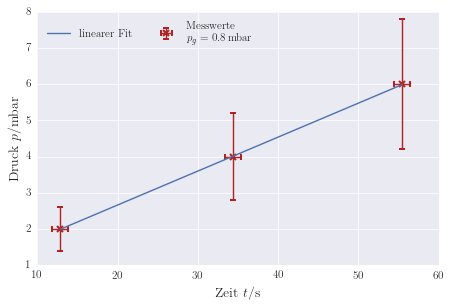

In [39]:
#Plot der Messwerte
plt.errorbar(noms(leak_rotarypump_3_time_mean_sys_err),noms(leak_rotarypump_3_pressure_err),
             xerr=stds(leak_rotarypump_3_time_mean_sys_err),yerr=stds(leak_rotarypump_3_pressure_err),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte\n $p_{g}=0.8\\,\\mathrm{mbar}$")

plt.plot(X,linear(X,*popt),label="linearer Fit")
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="mbar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Leckrate_Drehschieber_3.pdf")

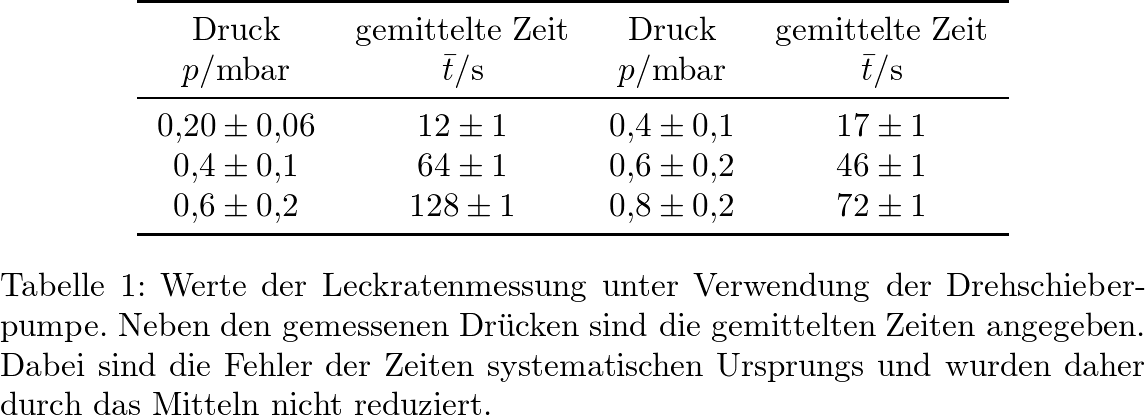

In [40]:
leak_rotary_Tab_0 = Table(siunitx=True,booktabs=True)
leak_rotary_Tab_0.label("Leckratenmessung_Drehschieber_0")
leak_rotary_Tab_0.caption("""Werte der Leckratenmessung unter Verwendung der Drehschieberpumpe.
                        Neben den gemessenen Drücken sind die gemittelten Zeiten angegeben. 
                        Dabei sind die Fehler der Zeiten systematischen Ursprungs und wurden 
                        daher durch das Mitteln nicht reduziert.""")
leak_rotary_Tab_0.addColumn(leak_rotarypump_0_pressure_err,title="Druck",symbol="p",unit="mbar")
leak_rotary_Tab_0.addColumn(leak_rotarypump_0_time_mean_sys_err,title="gemittelte Zeit",symbol="\\bar{t}",unit="s")
leak_rotary_Tab_0.addColumn(leak_rotarypump_1_pressure_err,title="Druck",symbol="p",unit="mbar")
leak_rotary_Tab_0.addColumn(leak_rotarypump_1_time_mean_sys_err,title="gemittelte Zeit",symbol="\\bar{t}",unit="s")

leak_rotary_Tab_1 = Table(siunitx=True,booktabs=True)
leak_rotary_Tab_1.label("Leckratenmessung_Drehschieber_1")
leak_rotary_Tab_1 = Table(siunitx=True,booktabs=True)
leak_rotary_Tab_1.caption("""Werte der Leckratenmessung unter Verwendung der Drehschieberpumpe.
                        Neben den gemessenen Drücken sind die gemittelten Zeiten angegeben. 
                        Dabei sind die Fehler der Zeiten systematischen Ursprungs und wurden 
                        daher durch das Mitteln nicht reduziert.""")
leak_rotary_Tab_1.addColumn(leak_rotarypump_2_pressure_err,title="Druck",symbol="p",unit="mbar")
leak_rotary_Tab_1.addColumn(leak_rotarypump_2_time_mean_sys_err,title="gemittelte Zeit",symbol="\\bar{t}",unit="s")
leak_rotary_Tab_1.addColumn(leak_rotarypump_3_pressure_err,title="Druck",symbol="p",unit="mbar")
leak_rotary_Tab_1.addColumn(leak_rotarypump_3_time_mean_sys_err,title="gemittelte Zeit",symbol="\\bar{t}",unit="s")

#leak_rotary_Tab_0.save(path_table+"Leckrate_Drehschieber_0.tex")
#leak_rotary_Tab_1.save(path_table+"Leckrate_Drehschieber_1.tex")

Image(leak_rotary_Tab_0.show(ipynb=True),width=800)
#Image(leak_rotary_Tab_1.show(ipynb=True),width=800)

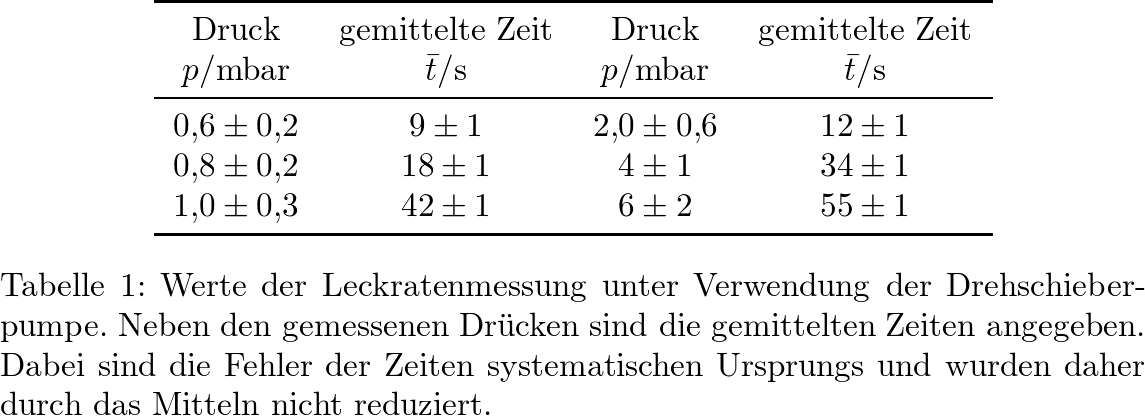

In [41]:
Image(leak_rotary_Tab_1.show(ipynb=True),width=800)

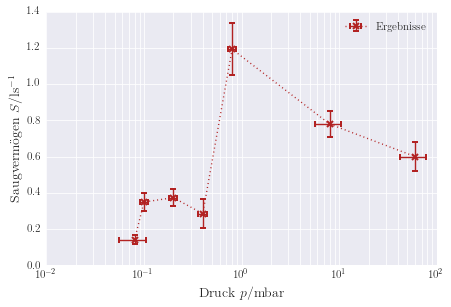

In [42]:
# Plot der Saugvermögen
leak_flow_rates_err = np.array([leak_flow_rate_0_err,leak_flow_rate_1_err,leak_flow_rate_2_err,leak_flow_rate_3_err])/1000000
flow_rates_err = np.hstack([leak_flow_rates_err,evac_flow_rates_err])
 
equi_pressures_err = np.hstack([leak_rotarypump_equipressures_err,evac_endpressures_err])
sorted_args = np.argsort(equi_pressures_err)
equi_pressures_err = equi_pressures_err[sorted_args]
flow_rates_err = flow_rates_err[sorted_args]

plt.errorbar(noms(equi_pressures_err),noms(flow_rates_err),
             xerr=stds(equi_pressures_err),yerr=stds(flow_rates_err),
             marker="x",mew=2,color="firebrick",linestyle="dotted",label="Ergebnisse")
plt.xscale("log")
plt.grid(b=True, which="both")
plt.xlabel(axis_label("Druck",sym="p",unit="mbar"),axis_font)
plt.ylabel(axis_label("Saugvermögen",sym="S",unit="ls^{-1}"),axis_font)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(path_graphics+"Saugvermoegen_Drehschieber.pdf")

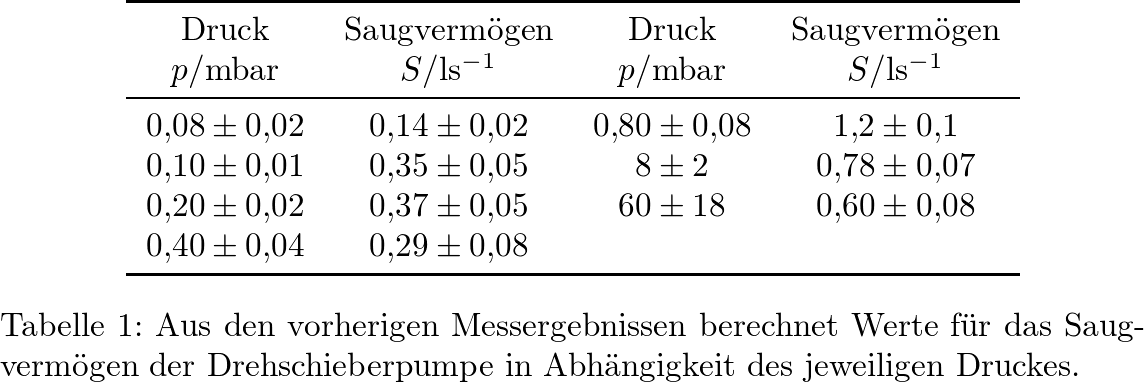

In [43]:
flow_rotary_Tab = Table(siunitx=True,booktabs=True)
flow_rotary_Tab.label("Saugvermoegen_Drehschieber")
flow_rotary_Tab.caption("""Aus den vorherigen Messergebnissen berechnet Werte für das 
                        Saugvermögen der Drehschieberpumpe in Abhängigkeit des jeweiligen Druckes.""")
flow_rotary_Tab.addColumn(equi_pressures_err[:4],title="Druck",symbol="p",unit="mbar")
flow_rotary_Tab.addColumn(flow_rates_err[:4],title="Saugvermögen",symbol="S",unit=r"ls^{-1}")
flow_rotary_Tab.addColumn(equi_pressures_err[4:],title="Druck",symbol="p",unit="mbar")
flow_rotary_Tab.addColumn(flow_rates_err[4:],title="Saugvermögen",symbol="S",unit=r"ls^{-1}")
Image(flow_rotary_Tab.show(ipynb=True,quiet=False),width=500)
#flow_rotary_Tab.save(path_table+"Saugvermoegen_Drehschieber.tex")

### Evakuierungskurver der Turbopumpe

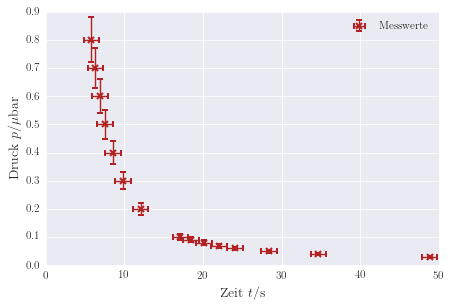

In [44]:
# Plot der Messwerte 
plt.errorbar(noms(evac_turbopump_time_mean_sys_err),noms(evac_turbopump_pressure_err),
             xerr=stds(evac_turbopump_time_mean_sys_err),yerr=stds(evac_turbopump_pressure_err),
             marker="x",mew=2,linestyle="",color="firebrick",label="Messwerte")

#plt.ylim(-10,110)
axis_scale(axis="y",scale=1e03)
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="\\mu bar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Evakuierungskurve_Turbo_exp.pdf")

In [45]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(evac_turbopump_time_mean_sys_err)
x_parts = np.split(x,[7,12]) 
y = noms(evac_turbopump_pressure_log_err)
y_parts = np.split(y,[7,12]) 

X0 = np.linspace(np.min(x),np.max(x),1000)


popt0,pcov0 = sp.optimize.curve_fit(linear,x_parts[0],y_parts[0])
evac_fit_err0 = fit_errors(popt0,pcov0)
popt1,pcov1 = sp.optimize.curve_fit(linear,x_parts[1],y_parts[1])
evac_fit_err1 = fit_errors(popt1,pcov1)
popt2,pcov2 = sp.optimize.curve_fit(linear,x_parts[2],y_parts[2])
evac_fit_err2 = fit_errors(popt2,pcov2)

print("Fit im 1.Bereich")
print_errors(evac_fit_err0,["a =","b ="])

print("Fit im 2.Bereich")
print_errors(evac_fit_err1,["a =","b ="])

print("Fit im 3.Bereich")
print_errors(evac_fit_err2,["a =","b ="])


Fit im 1.Bereich
a =  -0.232658127904 +/- 0.00766229475417
b =  1.31202567844 +/- 0.0643904309961
Fit im 2.Bereich
a =  -0.0917151063038 +/- 0.00139136386064
b =  -0.661277825589 +/- 0.0285758068287
Fit im 3.Bereich
a =  -0.0425609749525 +/- 0.00406186059955
b =  -1.96203941847 +/- 0.15545848225


In [46]:
# Saugvermögen (Volumendurchsatz) in den 3 Bereichen 
y_parts = np.split(evac_turbopump_pressure_err,[1,8,12])
evac_endpressures_err = np.array([p[0] for p in y_parts])
evac_endpressures_err = evac_endpressures_err[1:]
evac_flow_rate_0_err = - evac_turbopump_volume_recipient_err * evac_fit_err0[0] 
evac_flow_rate_1_err = - evac_turbopump_volume_recipient_err * evac_fit_err1[0]
evac_flow_rate_2_err = - evac_turbopump_volume_recipient_err * evac_fit_err2[0]

evac_flow_rates_err = np.array([evac_flow_rate_0_err,evac_flow_rate_1_err,evac_flow_rate_2_err])/1000000

print_errors(evac_endpressures_err,["P0 = ","P1 =","P2 ="])
print()
print_errors(evac_flow_rates_err,["S0 =","S1 =","S2 ="])


P0 =   0.0007 +/- 7e-05
P1 =   9e-05 +/- 9e-06
P2 =   5e-05 +/- 5e-06

S0 =  2.33570884392 +/- 0.16984232966
S1 =  0.92074919903 +/- 0.0613046451535
S2 =  0.427279487281 +/- 0.0492966509324


array([0.0008+/-8e-05, 0.0007+/-7.000000000000001e-05,
       0.0006+/-5.9999999999999995e-05, 0.0005+/-5e-05, 0.0004+/-4e-05,
       0.0003+/-2.9999999999999997e-05, 0.0002+/-2e-05, 0.0001+/-1e-05,
       9e-05+/-9e-06, 8e-05+/-8e-06, 7e-05+/-6.999999999999999e-06,
       6e-05+/-6e-06, 5e-05+/-5e-06, 4e-05+/-4e-06, 3e-05+/-3e-06], dtype=object)

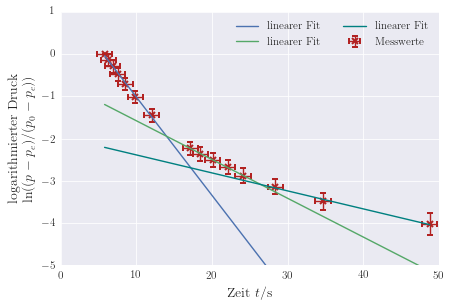

In [47]:
# Plot der logarithmierten Messwerte & 2.Fit
plt.errorbar(noms(evac_turbopump_time_mean_sys_err),noms(evac_turbopump_pressure_log_err),
             xerr=stds(evac_turbopump_time_mean_sys_err),yerr=stds(evac_turbopump_pressure_log_err),
             marker="x",mew=2,linestyle="",color="firebrick",label="Messwerte")
plt.plot(X0,linear(X0,*popt0),label="linearer Fit")
plt.plot(X0,linear(X0,*popt1),label="linearer Fit")
plt.plot(X0,linear(X0,*popt2),label="linearer Fit",color="teal")
plt.ylim(-5,1)
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("logarithmierter Druck\n",sym="\ln((p-p_e)/(p_0-p_e))"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
#plt.savefig(path_graphics+"Evakuierungskurve_Drehschieber_log_1.pdf")
evac_turbopump_pressure_err#

In [48]:
# Plots der logarithmierten Messwerte & Fits

# Definition der Fraben (r,g,b)
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

for i,popt,color in zip(range(3),[popt0,popt1,popt2],[blue,green,"teal"]):
    plt.errorbar(noms(evac_turbopump_time_mean_sys_err),noms(evac_turbopump_pressure_log_err),
                 xerr=stds(evac_turbopump_time_mean_sys_err),yerr=stds(evac_turbopump_pressure_log_err),
                 marker="x",mew=2,linestyle="",color="firebrick",label="Messwerte")
    plt.plot(X0,linear(X0,*popt),label="linearer Fit",color=color)
    plt.ylim(-5,1)
    plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
    plt.ylabel(axis_label("logarithmierter Druck\n",sym="\ln((p-p_e)/(p_0-p_e))"),axis_font)
    plt.legend(loc="best",ncol=2)
    plt.tight_layout()
    plt.savefig(path_graphics+"Evakuierungskurve_Turbo_log_{}.pdf".format(i))
    plt.clf()

### Tabelle Evakuierungskurve Turbopumpe

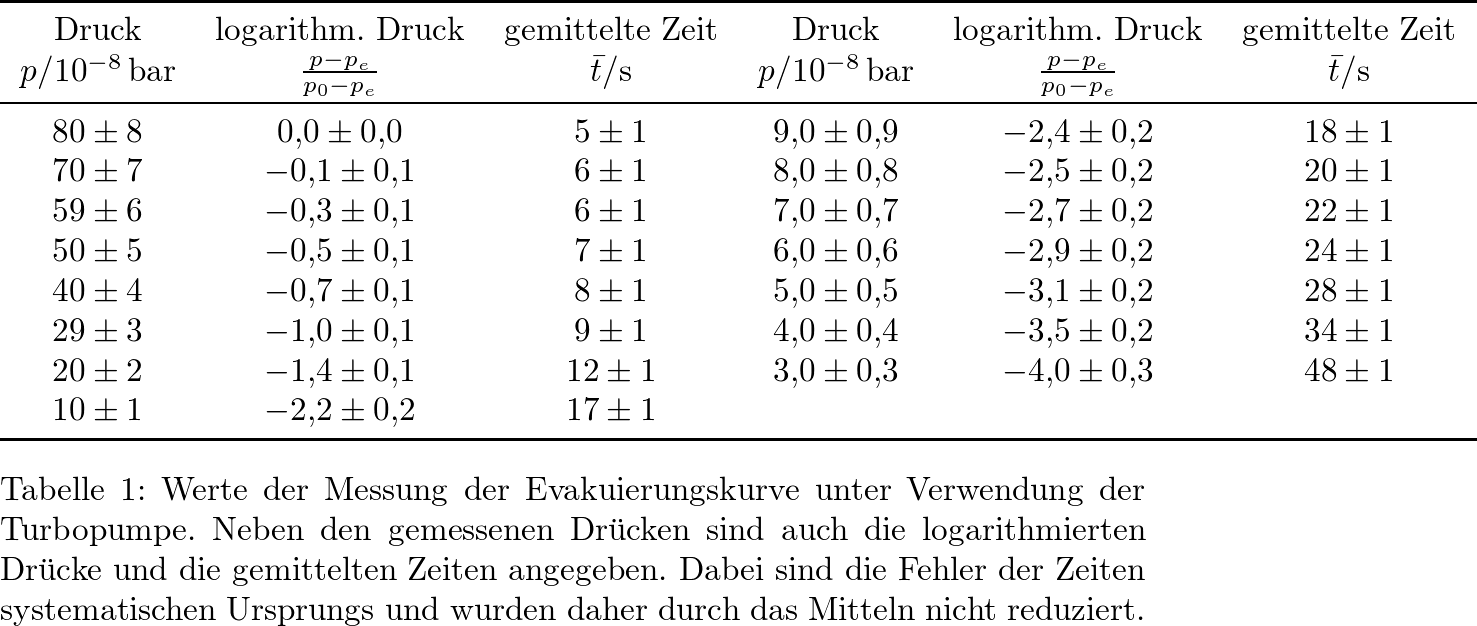

In [49]:
evac_turbo_Tab = Table(siunitx=True,booktabs=True)
evac_turbo_Tab.label("Evakuierungskurve_Turbo")
evac_turbo_Tab.caption("""Werte der Messung der Evakuierungskurve unter Verwendung der Turbopumpe.
                        Neben den gemessenen Drücken sind auch die logarithmierten Drücke und die gemittelten
                        Zeiten angegeben. Dabei sind die Fehler der Zeiten systematischen Ursprungs und wurden 
                        daher durch das Mitteln nicht reduziert.""")
evac_turbo_Tab.addColumn(evac_turbopump_pressure_err[:8]*1e05,title="Druck",symbol="p",unit="10^{-8}\\,bar")
evac_turbo_Tab.addColumn(evac_turbopump_pressure_log_err[:8],title="logarithm. Druck",symbol="\\frac{p-p_e}{p_0-p_e}")
evac_turbo_Tab.addColumn(evac_turbopump_time_mean_sys_err[:8],title="gemittelte Zeit",symbol="\\bar{t}",unit="s")
evac_turbo_Tab.addColumn(evac_turbopump_pressure_err[8:]*1e05,title="Druck",symbol="p",unit="10^{-8}\\,bar")
evac_turbo_Tab.addColumn(evac_turbopump_pressure_log_err[8:],title="logarithm. Druck",symbol="\\frac{p-p_e}{p_0-p_e}")
evac_turbo_Tab.addColumn(evac_turbopump_time_mean_sys_err[8:],title="gemittelte Zeit",symbol="\\bar{t}",unit="s")
#evac_turbo_Tab.save(path_table+"Evakuierungskurve_Turbo.tex")
Image(evac_turbo_Tab.show(ipynb=True,quiet=False),height=300)

###Leckratenmessung der Turbopumpe

In [50]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(leak_turbopump_0_time_mean_sys_err)
y = noms(leak_turbopump_0_pressure_err)

X = np.linspace(np.min(x),np.max(x),1000)

popt,pcov = sp.optimize.curve_fit(linear,x,y)
leak_fit_0_err = fit_errors(popt,pcov)
print_errors(leak_fit_0_err,["a =","b ="])

a =  3.40588066088e-05 +/- 6.58811930066e-07
b =  1.80309243975e-05 +/- 5.67821603704e-06


In [51]:
# Saugvermögen
V = leak_turbopump_volume_recipient_err 
Pg = leak_turbopump_equipressures_err[0]
leak_flow_rate_0_err = V/Pg * leak_fit_0_err[0]
print("Saugvermögen",leak_flow_rate_0_err/1000000)
Pg

Saugvermögen 8.5+/-1.0


4e-05+/-4e-06

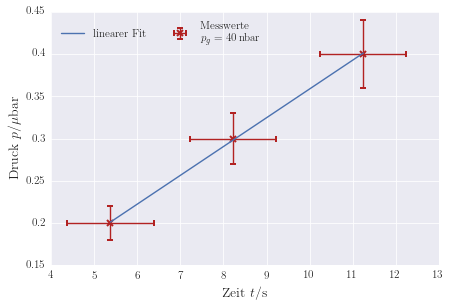

In [52]:
#Plot der Messwerte
plt.errorbar(noms(leak_turbopump_0_time_mean_sys_err),noms(leak_turbopump_0_pressure_err),
             xerr=stds(leak_turbopump_0_time_mean_sys_err),yerr=stds(leak_turbopump_0_pressure_err),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte\n $p_{g}=40\\,\\mathrm{nbar}$")
plt.plot(X,linear(X,*popt),label="linearer Fit")
axis_scale(axis="y",scale=1e03)
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="\\mu bar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Leckrate_Turbo_0.pdf")

In [53]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(leak_turbopump_1_time_mean_sys_err)
y = noms(leak_turbopump_1_pressure_err)

X = np.linspace(np.min(x),np.max(x),1000)

popt,pcov = sp.optimize.curve_fit(linear,x,y)
leak_fit_1_err = fit_errors(popt,pcov)
print_errors(leak_fit_1_err,["a =","b ="])

a =  5.25922439955e-05 +/- 1.43830165392e-06
b =  0.000163334902019 +/- 6.84644683494e-06


In [54]:
# Saugvermögen
V = leak_turbopump_volume_recipient_err 
Pg = leak_turbopump_equipressures_err[1]
leak_flow_rate_1_err = V/Pg * leak_fit_1_err[0]
print("Saugvermögen",leak_flow_rate_1_err/1000000)
Pg


Saugvermögen 8.8+/-1.1


6e-05+/-6e-06

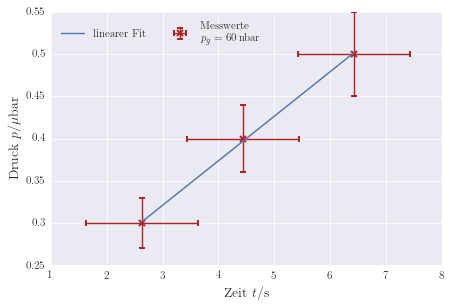

In [55]:
#Plot der Messwerte
plt.errorbar(noms(leak_turbopump_1_time_mean_sys_err),noms(leak_turbopump_1_pressure_err),
             xerr=stds(leak_turbopump_1_time_mean_sys_err),yerr=stds(leak_turbopump_1_pressure_err),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte\n $p_{g}=60\\,\\mathrm{nbar}$")
plt.plot(X,linear(X,*popt),label="linearer Fit")
axis_scale(axis="y",scale=1e03)
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="\\mu bar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Leckrate_Turbo_1.pdf")

In [56]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(leak_turbopump_2_time_mean_sys_err)
y = noms(leak_turbopump_2_pressure_err)

X = np.linspace(np.min(x),np.max(x),1000)

popt,pcov = sp.optimize.curve_fit(linear,x,y)
leak_fit_2_err = fit_errors(popt,pcov)
print_errors(leak_fit_2_err,["a =","b ="])

a =  6.34043095788e-05 +/- 9.9131259871e-06
b =  0.000232364707371 +/- 3.8067562092e-05


In [57]:
# Saugvermögen
V = leak_turbopump_volume_recipient_err 
Pg = leak_turbopump_equipressures_err[2]
leak_flow_rate_2_err = V/Pg * leak_fit_2_err[0]
print("Saugvermögen",leak_flow_rate_2_err/1000000)
Pg


Saugvermögen 7.9+/-1.6


8e-05+/-8e-06

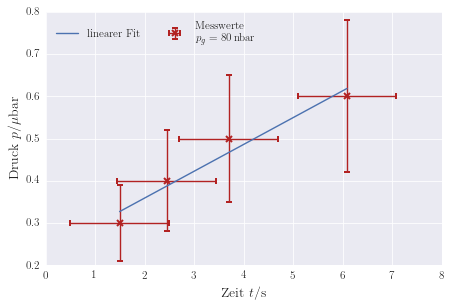

In [58]:
#Plot der Messwerte
plt.errorbar(noms(leak_turbopump_2_time_mean_sys_err),noms(leak_turbopump_2_pressure_err),
             xerr=stds(leak_turbopump_2_time_mean_sys_err),yerr=stds(leak_turbopump_2_pressure_err),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte\n $p_{g}=80\\,\\mathrm{nbar}$")
plt.plot(X,linear(X,*popt),label="linearer Fit")
axis_scale(axis="y",scale=1e03)
#plt.ylim(0.0002,0.0009)
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="\\mu bar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Leckrate_Turbo_2.pdf")

In [59]:
# Regression der Messwerte
def linear(x,a,b):
    return a*x + b
x = noms(leak_turbopump_3_time_mean_sys_err)
y = noms(leak_turbopump_3_pressure_err)

X = np.linspace(np.min(x),np.max(x),1000)

popt,pcov = sp.optimize.curve_fit(linear,x,y)
leak_fit_3_err = fit_errors(popt,pcov)
print_errors(leak_fit_3_err,["a =","b ="])

a =  0.000108108108257 +/- 7.99158131946e-06
b =  0.000190630630135 +/- 2.78080079405e-05


In [60]:
# Saugvermögen
V = leak_turbopump_volume_recipient_err 
Pg = leak_turbopump_equipressures_err[3]
leak_flow_rate_3_err = V/Pg * leak_fit_3_err[0]
print("Saugvermögen",leak_flow_rate_3_err/1000000)
Pg


Saugvermögen 10.8+/-1.5


0.0001+/-1e-05

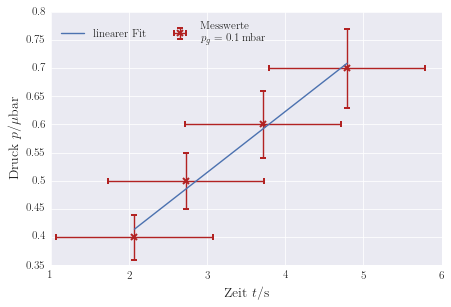

In [61]:
#Plot der Messwerte
plt.errorbar(noms(leak_turbopump_3_time_mean_sys_err),noms(leak_turbopump_3_pressure_err),
             xerr=stds(leak_turbopump_3_time_mean_sys_err),yerr=stds(leak_turbopump_3_pressure_err),
             marker="x",mew=2,color="firebrick",linestyle="",label="Messwerte\n $p_{g}=0.1\\,\\mathrm{mbar}$")
plt.plot(X,linear(X,*popt),label="linearer Fit")
axis_scale(axis="y",scale=1e03)
plt.xlabel(axis_label("Zeit",sym="t",unit="s"),axis_font)
plt.ylabel(axis_label("Druck",sym="p",unit="\\mu bar"),axis_font)
plt.legend(loc="best",ncol=2)
plt.tight_layout()
plt.savefig(path_graphics+"Leckrate_Turbo_3.pdf")

### Tabelle zur Leckratenmessung der Turbopumpe

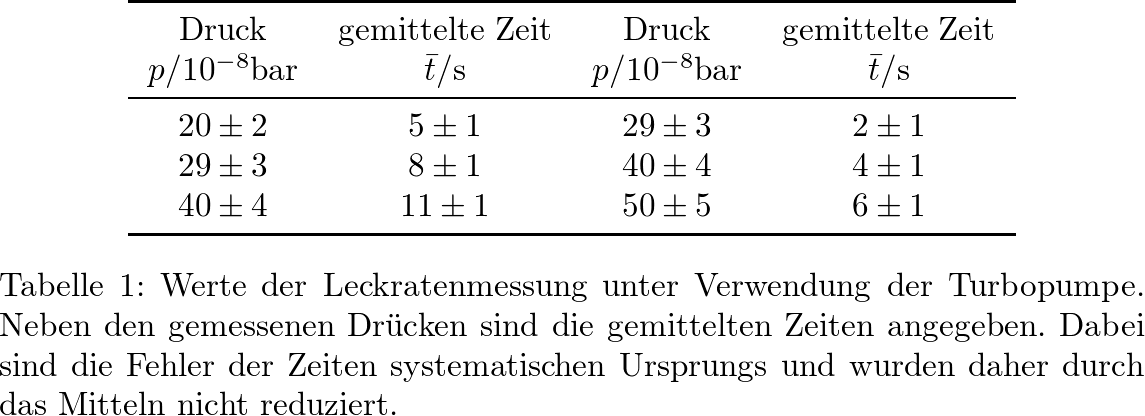

In [62]:
leak_turbo_Tab_0 = Table(siunitx=True,booktabs=True)
leak_turbo_Tab_0.label("Leckratenmessung_Turbo_0")
leak_turbo_Tab_0.caption("""Werte der Leckratenmessung unter Verwendung der Turbopumpe.
                        Neben den gemessenen Drücken sind die gemittelten Zeiten angegeben. 
                        Dabei sind die Fehler der Zeiten systematischen Ursprungs und wurden 
                        daher durch das Mitteln nicht reduziert.""")
leak_turbo_Tab_0.addColumn(leak_turbopump_0_pressure_err*1e05,title="Druck",symbol="p",unit="10^{-8}bar")
leak_turbo_Tab_0.addColumn(leak_turbopump_0_time_mean_sys_err,title="gemittelte Zeit",symbol="\\bar{t}",unit="s")
leak_turbo_Tab_0.addColumn(leak_turbopump_1_pressure_err*1e05,title="Druck",symbol="p",unit="10^{-8}bar")
leak_turbo_Tab_0.addColumn(leak_turbopump_1_time_mean_sys_err,title="gemittelte Zeit",symbol="\\bar{t}",unit="s")

leak_turbo_Tab_1 = Table(siunitx=True,booktabs=True)
leak_turbo_Tab_1.label("Leckratenmessung_Turbo_1")
leak_turbo_Tab_1 = Table(siunitx=True,booktabs=True)
leak_turbo_Tab_1.caption("""Werte der Leckratenmessung unter Verwendung der Turbopumpe.
                        Neben den gemessenen Drücken sind die gemittelten Zeiten angegeben. 
                        Dabei sind die Fehler der Zeiten systematischen Ursprungs und wurden 
                        daher durch das Mitteln nicht reduziert.""")
leak_turbo_Tab_1.addColumn(leak_turbopump_2_pressure_err*1e05,title="Druck",symbol="p",unit="10^{-8}bar")
leak_turbo_Tab_1.addColumn(leak_turbopump_2_time_mean_sys_err,title="gemittelte Zeit",symbol="\\bar{t}",unit="s")
leak_turbo_Tab_1.addColumn(leak_turbopump_3_pressure_err*1e05,title="Druck",symbol="p",unit="10^{-8}bar")
leak_turbo_Tab_1.addColumn(leak_turbopump_3_time_mean_sys_err,title="gemittelte Zeit",symbol="\\bar{t}",unit="s")

#leak_turbo_Tab_0.save(path_table+"Leckrate_Turbo_0.tex")
#leak_turbo_Tab_1.save(path_table+"Leckrate_Trubo_1.tex")

Image(leak_turbo_Tab_0.show(ipynb=True),width=800)
#Image(leak_turbo_Tab_1.show(ipynb=True),width=800)

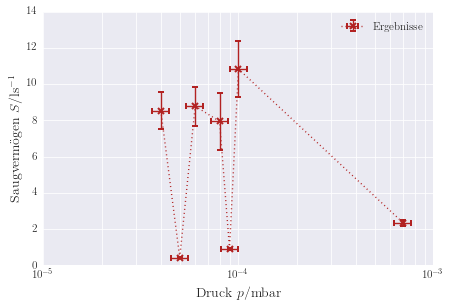

In [63]:
# Plot der Saugvermögen
leak_flow_rates_err = np.array([leak_flow_rate_0_err,leak_flow_rate_1_err,leak_flow_rate_2_err,leak_flow_rate_3_err])/1000000
flow_rates_err = np.hstack([leak_flow_rates_err,evac_flow_rates_err])
 
equi_pressures_err = np.hstack([leak_turbopump_equipressures_err,evac_endpressures_err])
sorted_args = np.argsort(equi_pressures_err)
equi_pressures_err = equi_pressures_err[sorted_args]
flow_rates_err = flow_rates_err[sorted_args]

plt.errorbar(noms(equi_pressures_err),noms(flow_rates_err),
             xerr=stds(equi_pressures_err),yerr=stds(flow_rates_err),
             marker="x",mew=2,color="firebrick",linestyle="dotted",label="Ergebnisse")
plt.xscale("log")
plt.grid(b=True, which="both")
plt.xlabel(axis_label("Druck",sym="p",unit="mbar"),axis_font)
plt.ylabel(axis_label("Saugvermögen",sym="S",unit="ls^{-1}"),axis_font)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(path_graphics+"Saugvermoegen_Turbo.pdf")



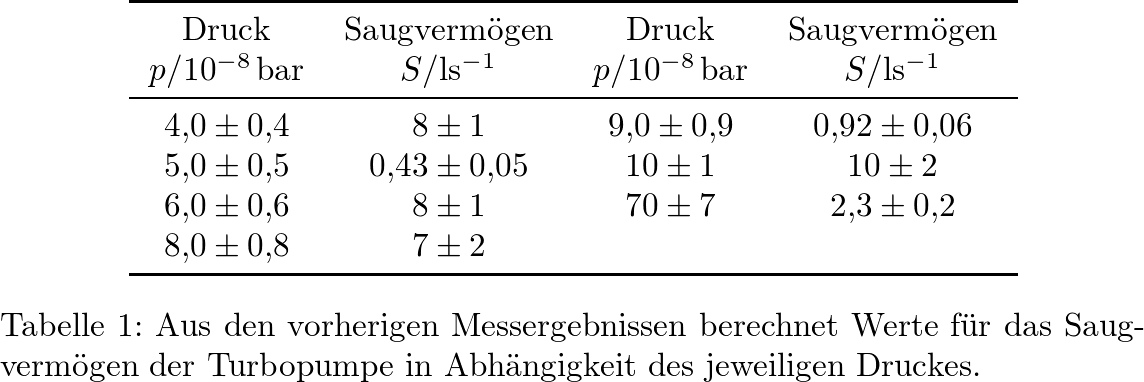

In [64]:
flow_turbo_Tab = Table(siunitx=True,booktabs=True)
flow_turbo_Tab.label("Saugvermoegen_Drehschieber")
flow_turbo_Tab.caption("""Aus den vorherigen Messergebnissen berechnet Werte für das 
                       Saugvermögen der Turbopumpe in Abhängigkeit des jeweiligen Druckes.""")
flow_turbo_Tab.addColumn(equi_pressures_err[:4]*1e05,title="Druck",symbol="p",unit="10^{-8}\\,bar")
flow_turbo_Tab.addColumn(flow_rates_err[:4],title="Saugvermögen",symbol="S",unit=r"ls^{-1}")
flow_turbo_Tab.addColumn(equi_pressures_err[4:]*1e05,title="Druck",symbol="p",unit="10^{-8}\\,bar")
flow_turbo_Tab.addColumn(flow_rates_err[4:],title="Saugvermögen",symbol="S",unit=r"ls^{-1}")
Image(flow_turbo_Tab.show(ipynb=True,quiet=False),width=500)
#flow_turbo_Tab.save(path_table+"Saugvermoegen_Turbo.tex")

In [65]:
print_errors(equi_pressures_err)
print_errors(flow_rates_err)

4e-05 +/- 4e-06
5e-05 +/- 5e-06
6e-05 +/- 6e-06
8e-05 +/- 8e-06
9e-05 +/- 9e-06
0.0001 +/- 1e-05
0.0007 +/- 7e-05
8.53624441057 +/- 1.03103129277
0.427279487281 +/- 0.0492966509324
8.78755097524 +/- 1.07489514365
7.94559083448 +/- 1.562252604
0.92074919903 +/- 0.0613046451535
10.8381628922 +/- 1.52038968129
2.33570884392 +/- 0.16984232966
